# Ticket Classification Assignment
<font color=green size=5>- Shashank Pawaskar (C48)</font>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

**Note : Used Google Colab for the project, sharing the link / access below**

https://drive.google.com/drive/folders/1iHdw43W2wjRVQ5rlQd2-9NYgu04mFbrx?usp=sharing


**GitHub Repository - Includes the Jupyter File, Dataset (JSon) and Models Saved during execution**

https://github.com/ShashankPawas/NLP-Ticket-Classification

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

# Libraries for model evaluation metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint
import os
import json

In [2]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk

In [3]:
# Import Textblob for extracting noun phrases
!pip install textblob

from textblob import TextBlob

In [4]:
# Installing wordcloud
!pip install wordcloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [5]:
# Setting Ignore Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Setting max rows and columns
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [6]:
# Class for Print Formatting
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
# Setting root path for the notebook and data set
root_path = '/content/gdrive/MyDrive/Automatic Ticket Classification/'  #change dir to your project folder
os.chdir(root_path)

In [9]:
# Opening JSON file
f = open('complaints-2021-05-14_08_16.json')

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

In [10]:
# Check whether data is loaded
df.shape

(78313, 22)

**Data Loaded - 78,313 Rows with 22 Columns**

## Data preparation

In [11]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [12]:
#print the column names
#keys=df.keys()

print(color.BOLD+color.UNDERLINE+color.BLUE+'Column Names in the Loaded JSon file are :'+color.END)
print(df.columns)

Column Names in the Loaded JSon file are :
Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [13]:
# Get top 5 rows of the dataset
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [14]:
#Assign new column names
df.columns = ['Index', 'Type', 'Id', 'Score', 'Tags', 'Zip_Code',
       'Complaint_Id', 'Issue', 'Date_Received',
       'State', 'Consumer_Disputed', 'Product',
       'Company_Response', 'Company', 'Submitted_Via',
       'Date_Sent_To_Company', 'Company_Public_Response',
       'Sub_Product', 'Timely',
       'Complaint_What_Happened', 'Sub_Issue',
       'Consumer_Consent_Provided']
df.columns

Index(['Index', 'Type', 'Id', 'Score', 'Tags', 'Zip_Code', 'Complaint_Id',
       'Issue', 'Date_Received', 'State', 'Consumer_Disputed', 'Product',
       'Company_Response', 'Company', 'Submitted_Via', 'Date_Sent_To_Company',
       'Company_Public_Response', 'Sub_Product', 'Timely',
       'Complaint_What_Happened', 'Sub_Issue', 'Consumer_Consent_Provided'],
      dtype='object')

###### Assign nan in place of blanks in the complaints column

In [15]:
# Lets first check percentage of columns with missing data
round(df.isna().sum()*100/78313,2)  ## we have 78,313 rows

Index                         0.00
Type                          0.00
Id                            0.00
Score                         0.00
Tags                         86.08
Zip_Code                      8.63
Complaint_Id                  0.00
Issue                         0.00
Date_Received                 0.00
State                         2.54
Consumer_Disputed             0.00
Product                       0.00
Company_Response              0.00
Company                       0.00
Submitted_Via                 0.00
Date_Sent_To_Company          0.00
Company_Public_Response      99.99
Sub_Product                  13.50
Timely                        0.00
Complaint_What_Happened       0.00
Sub_Issue                    59.12
Consumer_Consent_Provided     1.29
dtype: float64

In [16]:
# Lets check for the column in question 'Complaint_What_Happened' for empty values
empty_count = df['Complaint_What_Happened'].str.count('^$').sum()

print(f'Empty Complaint_What_Happened count: {empty_count}')

Empty Complaint_What_Happened count: 57241


In [17]:
# Lets replace the emplty values for the column to NaN
df['Complaint_What_Happened'].replace("", np.nan, inplace=True)

# Lets check again
empty_count = df['Complaint_What_Happened'].str.count('^$').sum()

print(f'Empty Complaint_What_Happened count: {empty_count}')

Empty Complaint_What_Happened count: 0.0


In [18]:
# Lets again check percentage of columns with missing data
round(df.isna().sum()*100/78313,2)

Index                         0.00
Type                          0.00
Id                            0.00
Score                         0.00
Tags                         86.08
Zip_Code                      8.63
Complaint_Id                  0.00
Issue                         0.00
Date_Received                 0.00
State                         2.54
Consumer_Disputed             0.00
Product                       0.00
Company_Response              0.00
Company                       0.00
Submitted_Via                 0.00
Date_Sent_To_Company          0.00
Company_Public_Response      99.99
Sub_Product                  13.50
Timely                        0.00
Complaint_What_Happened      73.09
Sub_Issue                    59.12
Consumer_Consent_Provided     1.29
dtype: float64

**'Compliant_What_Happened' is key for us to decipher and classify the ticket, this column has 73.09% of NaN values, which is not going to help us achieve the objective. Hence we remove the rows where 'Complain What Happened' column has NaN values.**

In [19]:
#Remove all rows where complaints column is nan
df.dropna(subset=['Complaint_What_Happened'], inplace=True)

#New shape of df
df.shape

(21072, 22)

**Now we have 21,072 rows with 22 columns.**

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [20]:
# Write your function here to clean the text and remove all the unnecessary elements.
# Reference - https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-language-model-nlp-python-code/#:~:text=A%202%2Dgram%20(or%20bigram,or%20%E2%80%9Con%20Analytics%20Vidhya%E2%80%9D.

def text_sanitize(complain_text):

    # First - Make the text lowercase
    complain_text=complain_text.lower()

    # Next - Remove text in square brackets
    complain_text=re.sub(r'\[.*?\]','',complain_text)

    # Then - Remove punctuation
    complain_text=re.sub(r'[%s]%re.escape(string.punctuation)','',complain_text)

    # Lastly - Remove words containing numbers
    pattern = '\w*\d\w*'
    complain_text = re.sub(pattern, '', complain_text)

    return complain_text

In [21]:
# Apply the function Text_sanitize to the column 'Complaint_What_Happened'
df_clean = pd.DataFrame(df['Complaint_What_Happened'].apply(text_sanitize))

In [22]:
# Write your function to Lemmatize the texts
def lemmatize_input(complain_text):

    # Initialize empty list to store lemmas
    lemma_list = []

    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(complain_text)
    for word in document:
        lemma_list.append(word.lemma_)

    # return string converted form of the list of lemmas
    return " ".join(lemma_list)

In [23]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean['complaint_lemma'] = df_clean['Complaint_What_Happened'].apply(lemmatize_input)

In [24]:
df_clean.head()

,Complaint_What_Happened,complaint_lemma
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant ."
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ , while try to book a xxxx xxxx ticket , I come across an offer for { $ . } to be apply towards the ticket if I apply for a reward card . I put in my information for the offer and within less than a minute , be notify via the screen that a decision could not be make . I immediately contact xxxx and be refer to chase bank . I then immediately contact chase b

In [25]:
!pip install nltk
import nltk
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [26]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
#Write your function to extract the POS tags
def pos_tag(text):
    text_sent = []
    blob = TextBlob(text)
    text_sent = [word for (word,tag) in blob.tags if tag=='NN']
    return " ".join(text_sent)

In [28]:
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"]
df_clean["complaint_POS_rem"] = df_clean['complaint_lemma'].apply(pos_tag)

In [29]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,Complaint_What_Happened,complaint_lemma,complaint_POS_rem
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.","on xx / xx/ , while try

In [30]:
df_clean.shape

(21072, 3)

**We now have dataframe with Orginal 'Complaint_What_Happened', Lemmatized and POS Tagged  for the same Column.**

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




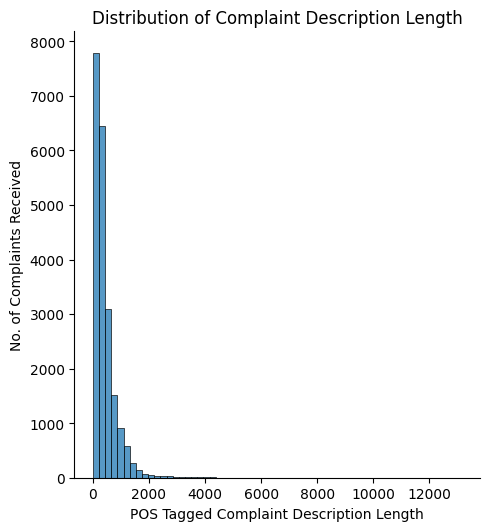

In [31]:
# Write your code here to visualise the data according to the 'Complaint' character length
POS_char_len = [len(each_sent) for each_sent in df_clean['complaint_POS_rem']]

sns.displot(POS_char_len, kind='hist', bins=60)
plt.xlabel("POS Tagged Complaint Description Length")
plt.ylabel("No. of Complaints Received")
plt.title("Distribution of Complaint Description Length")

plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

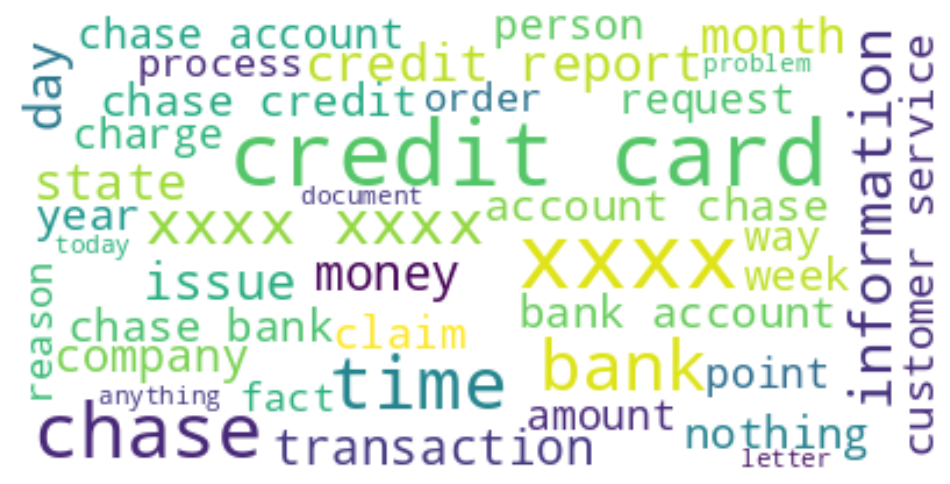

In [32]:
# Using a word cloud find the top 40 words by frequency among all the articles after processing the text
# Reference - https://towardsdatascience.com/identify-top-topics-using-word-cloud-9c54bc84d911

stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=40, max_words=40, background_color="white", random_state=100, stopwords=stopwords).generate(str(df_clean['complaint_POS_rem']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [33]:
# Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_rem'].str.replace('-PRON-', '')

In [34]:
df_clean.head()

,Complaint_What_Happened,complaint_lemma,complaint_POS_rem,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,card application identity consent service credit identity applicant
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by t

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [35]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
# Reference - https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5
# Reference - https://machinelearningknowledge.ai/generating-unigram-bigram-trigram-and-ngrams-in-nltk/

# Defining a function for
def get_ngram(text, n=30, ngram=(1,1)):  # Getting top 30 unigram frequency n=30

    vector = CountVectorizer(stop_words='english', ngram_range = ngram).fit(text)
    BoW = vector.transform(text)  # Getting words - Bag of Words
    SoW = BoW.sum(axis=0)         # Getting Sum of Words from the Bag of Words
    word_freq = [(word, SoW[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n] # Return the top number of words, passed as parameter (in this case 30)

In [36]:
# find and list the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_unigram = get_ngram(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30_unigram, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,chase,49221
1,account,47915
2,xxxx,43303
3,credit,34300
4,card,29633
5,bank,28503
6,payment,21338
7,time,16281
8,charge,15159
9,day,13073


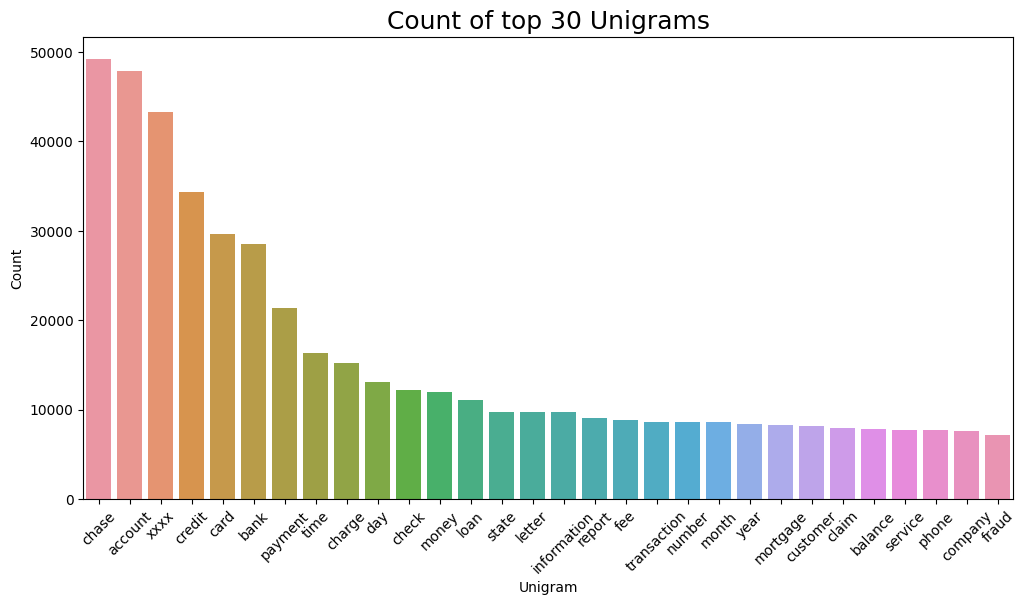

In [37]:
# Plotting top 30 Unigrams
plt.figure(figsize=[12,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams",fontdict={'fontsize': 18})
plt.show()

In [38]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,chase,49221
1,account,47915
2,xxxx,43303
3,credit,34300
4,card,29633
5,bank,28503
6,payment,21338
7,time,16281
8,charge,15159
9,day,13073


In [39]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_bigram = get_ngram(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30_bigram, columns=['bigram', 'count'])
df_bigram

,bigram,count
0,credit card,12878
1,xxxx xxxx,6249
2,credit report,3964
3,customer service,3082
4,chase credit,3064
5,chase bank,2938
6,account chase,2762
7,bank account,2751
8,chase account,2718
9,account account,2307


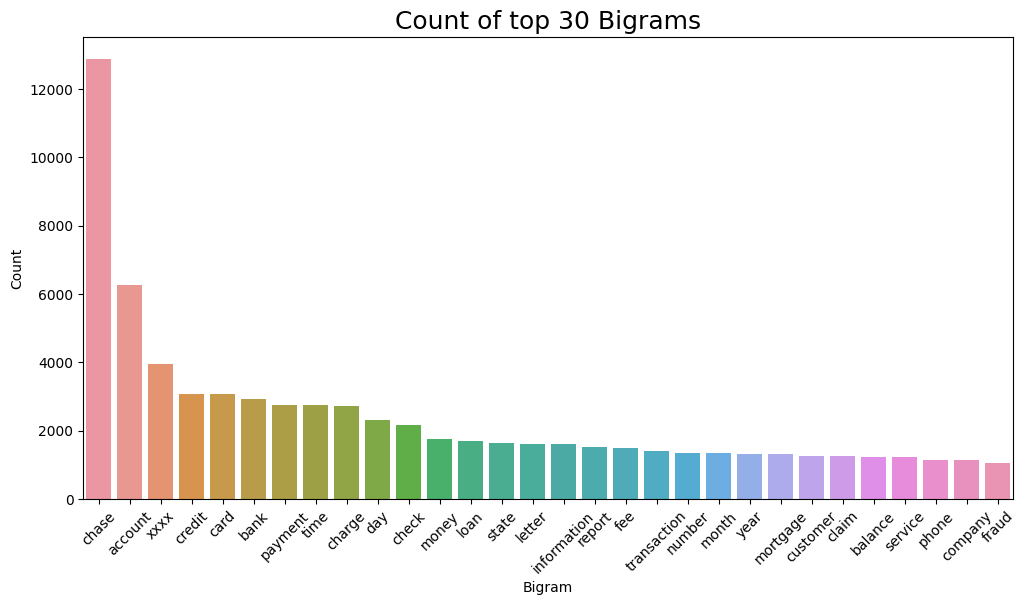

In [40]:
# Plotting top 30 Bigrams
plt.figure(figsize=[12,6])
sns.barplot(x=df_unigram['unigram'], y=df_bigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Count of top 30 Bigrams",fontdict={'fontsize': 18})
plt.show()

In [41]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12878
1,xxxx xxxx,6249
2,credit report,3964
3,customer service,3082
4,chase credit,3064
5,chase bank,2938
6,account chase,2762
7,bank account,2751
8,chase account,2718
9,account account,2307


In [42]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_trigram = get_ngram(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30_bigram, columns=['trigram', 'count'])
df_trigram

,trigram,count
0,credit card,12878
1,xxxx xxxx,6249
2,credit report,3964
3,customer service,3082
4,chase credit,3064
5,chase bank,2938
6,account chase,2762
7,bank account,2751
8,chase account,2718
9,account account,2307


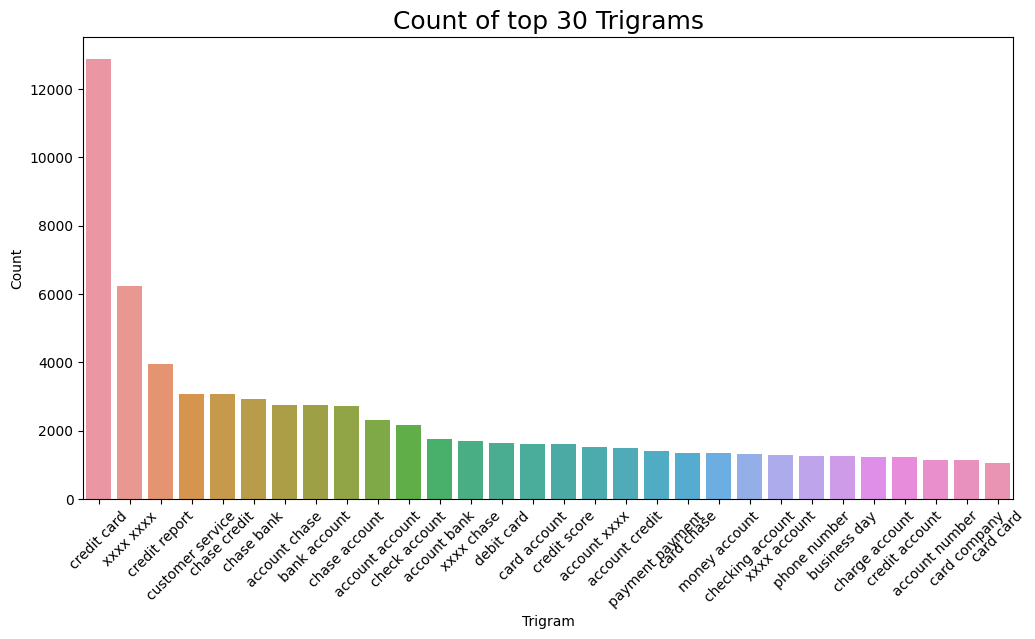

In [43]:
# Plotting top 30 Bigrams
plt.figure(figsize=[12,6])
sns.barplot(x=df_trigram['trigram'], y=df_trigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Count of top 30 Trigrams",fontdict={'fontsize': 18})
plt.show()

In [44]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,credit card,12878
1,xxxx xxxx,6249
2,credit report,3964
3,customer service,3082
4,chase credit,3064
5,chase bank,2938
6,account chase,2762
7,bank account,2751
8,chase account,2718
9,account account,2307


**The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis**

In [45]:
# Removing the masked customer words 'xxxx'
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [46]:
df_clean.shape

(21072, 4)

In [47]:
#All masked texts has been removed
df_clean.head()

,Complaint_What_Happened,complaint_lemma,complaint_POS_rem,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent,card agent upgrade date agent information order account change date consent recording agent
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,card application identity consent service credit identity applicant
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase r

In [48]:
df_clean_copy = df_clean.copy()

In [49]:
#df_clean = df_clean_copy.copy()
df_clean_copy.shape

(21072, 4)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [50]:
#Write your code here to initialise the TfidfVectorizer
# Reference - nmf-imdb-movie-reviews.ipnyb
vect = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [51]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = vect.fit_transform(df_clean['Complaint_clean'])

In [52]:
pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names_out()).head()

aa  aarp  abandon  abandonment  abatement  abbreviation  abd  abide  \
0  0.0   0.0      0.0          0.0        0.0           0.0  0.0    0.0   
1  0.0   0.0      0.0          0.0        0.0           0.0  0.0    0.0   
2  0.0   0.0      0.0          0.0        0.0           0.0  0.0    0.0   
3  0.0   0.0      0.0          0.0        0.0           0.0  0.0    0.0   
4  0.0   0.0      0.0          0.0        0.0           0.0  0.0    0.0   

   ability  abovementione  abrupt  absence  absent  absolute  absolve  absurd  \
0      0.0            0.0     0.0      0.0     0.0       0.0      0.0     0.0   
1      0.0            0.0     0.0      0.0     0.0       0.0      0.0     0.0   
2      0.0            0.0     0.0      0.0     0.0       0.0      0.0     0.0   
3      0.0            0.0     0.0      0.0     0.0       0.0      0.0     0.0   
4      0.0            0.0     0.0      0.0     0.0       0.0      0.0     0.0   

   absurdity  abundance  abuse  abuser   ac  acc  acccount  accelerate  \
0        0.0        0.0    0.0     0.0  0.0  0.0       0.0         0.0   
1        0.0        0.0    0.0     0.0  0.0  0.0       0.0         0.0   
2        0.0        0.0    0.0     0.0  0.0  0.0       0.0         0.0   
3        0.0        0.0    0.0     0.0  0.0  0.0       0.0         0.0   
4        0.0        0.0    0.0     0.0  0.0  0.0       0.0         0.0   

   acceleration  accent  accept  acceptance  accepting  access  accessibility  \
0           0.0     0.0     0.0         0.0        0.0     0.0            0.0   
1           0.0     0.0     0.0         0.0        0.0     0.0            0.0   
2           0.0     0.0     0.0         0.0        0.0     0.0            0.0   
3           0.0     0.0     0.0         0.0        0.0     0.0            0.0   
4           0.0     0.0     0.0         0.0        0.0     0.0            0.0   

   accessory  accident  accidental  acco  accommodate  accommodating  \
0        0.0       0.0         0.0   0.0          0.0            0.0   
1        0.0       0.0         0.0   0.0          0.0            0.0   
2        0.0       0.0         0.0   0.0          0.0            0.0   
3        0.0       0.0         0.0   0.0          0.0            0.0   
4        0.0       0.0         0.0   0.0          0.0            0.0   

   accommodation  accomodation  accompany  accomplice  accomplish  accont  \
0            0.0           0.0        0.0         0.0         0.0     0.0   
1            0.0           0.0        0.0         0.0         0.0     0.0   
2            0.0           0.0        0.0         0.0         0.0     0.0   
3            0.0           0.0        0.0         0.0         0.0     0.0   
4            0.0           0.0        0.0         0.0         0.0     0.0   

   accord  accordance  accorde  accou  accouint  accoun  accound   account  \
0     0.0         0.0      0.0    0.0       0.0     0.0      0.0  0.079169   
1     0.0         0.0      0.0    0.0       0.0     0.0      0.0  0.083708   
2     0.0         0.0      0.0    0.0       0.0     0.0      0.0  0.000000   
3     0.0         0.0      0.0    0.0       0.0     0.0      0.0  0.120855   
4     0.0         0.0      0.0    0.0       0.0     0.0      0.0  0.135672   

   accountability  accountable  accountant  accountholder  accounting  \
0             0.0          0.0         0.0            0.0         0.0   
1             0.0          0.0         0.0            0.0         0.0   
2             0.0          0.0         0.0            0.0         0.0   
3             0.0          0.0         0.0            0.0         0.0   
4             0.0          0.0         0.0            0.0         0.0   

   accounts  accout  accredit  accrual  accrue  acct  accumulate  \
0       0.0     0.0       0.0      0.0     0.0   0.0         0.0   
1       0.0     0.0       0.0      0.0     0.0   0.0         0.0   
2       0.0     0.0       0.0      0.0     0.0   0.0         0.0   
3       0.0     0.0       0.0      0.0     0.0   0.0      

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

#### Find the Best Number of Clusters

**References :**

https://www.analyticsvidhya.com/blog/2021/05/topic-modelling-in-natural-language-processing/

https://www.kaggle.com/code/rockystats/topic-modelling-using-nmf

https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c

In [53]:
from sklearn.decomposition import NMF
from sklearn import decomposition
import re, joblib

In [54]:
import warnings
warnings.filterwarnings("ignore")
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import common_texts
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

In [55]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['Complaint_clean']
dataset = [d.split() for d in texts]

In [56]:
# Check whether the Complaint_clean has been split into individual words
print(dataset[0])

['morning', 'name', 'stop', 'bank', 'cardmember', 'service', 'ask', 'debt', 'verification', 'statement', 'bank', 'debt', 'mail', 'month', 'debt', 'right', 'information', 'consumer', 'chase', 'account', 'thank', 'advance', 'help']


In [57]:
# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(dataset)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

In [58]:
# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 11))

In [59]:
data_topic_score = pd.DataFrame(columns=['Model', 'No. of Topics','Coherence'] )

###### Find Best Number of Topics using NMF

**To evaluate the best number of topics, we will use the coherence score.**

**Non-negative matrix factorization (NMF) is a decomposition technique for the analysis of high dimensional data to automatically extracts sparse and meaningful features from a set of nonnegative data vectors.**

In [60]:
# Run the nmf model and calculate the coherence score
# for each number of topics
nmf_coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        random_state=42
    )
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=dataset,
        dictionary=dictionary,
        coherence='c_v'
    )
    nmf_coherence_scores.append(round(cm.get_coherence(), 5))
    data_topic_score.loc[len(data_topic_score.index)] = ['NMF', num, round(cm.get_coherence(), 5)]


In [61]:
data_topic_score

,Model,No. of Topics,Coherence
0,NMF,5,0.40529
1,NMF,6,0.42466
2,NMF,7,0.41501
3,NMF,8,0.43485
4,NMF,9,0.43948
5,NMF,10,0.42939


In [62]:
# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, nmf_coherence_scores))
best_num_topics_nmf = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

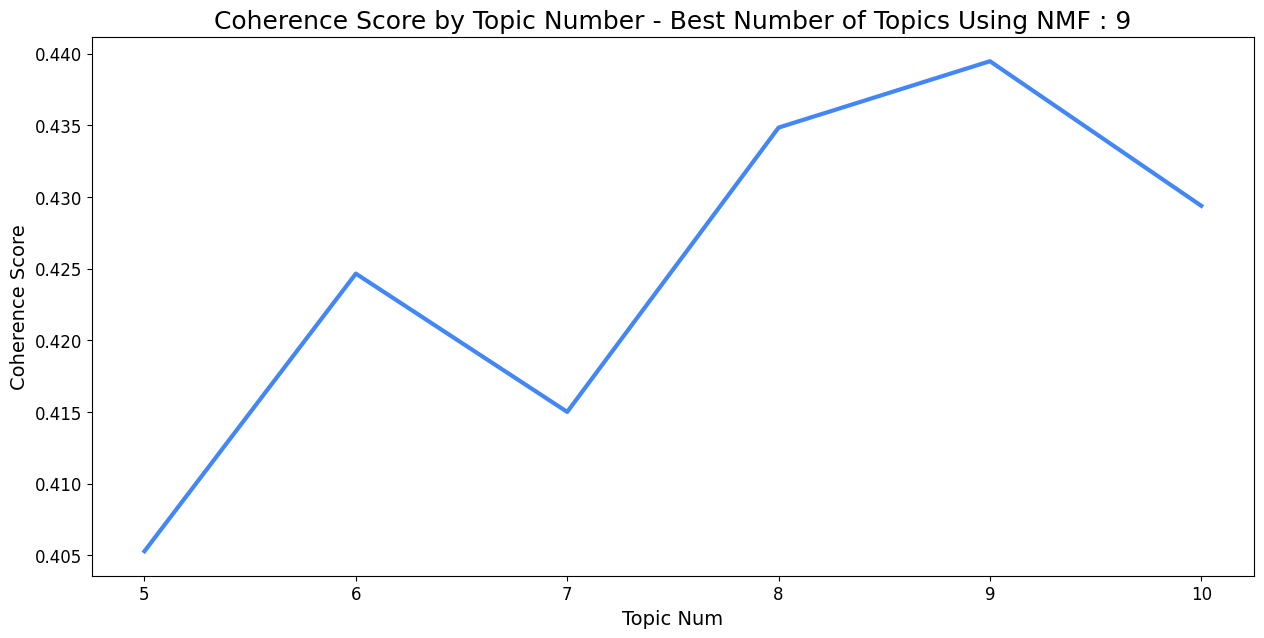

In [63]:
# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    nmf_coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics Using NMF : {}'.format(best_num_topics_nmf), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 1), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [64]:
# Print Scores
print(color.BOLD+color.CYAN+"Best Number of Topics using NMF : "+str(best_num_topics_nmf)+color.END)

Best Number of Topics using NMF : 9


**From above we have the Best Number of Topics derived using NMF Coherence Model**

**We will also check what topics have been selected and see whether these can be grouped together to meet the Assignment requirement to classify tickets into 5 categories, using our Business Domain Knowledge**




###### Best Number of Topics Using LSI


**Latent semantic indexing (LSI) is an indexing and retrieval method that uses a mathematical technique called singular value decomposition (SVD) to identify patterns in the relationships between the terms and concepts contained in an unstructured collection of text.**

In [65]:
from gensim import models
lsi_coherence_scores= []


for num in topic_nums:
    lsi_model = models.LsiModel(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000
        )

    cm = CoherenceModel(
        model=lsi_model,
        texts=dataset,
        dictionary=dictionary,
        coherence='c_v')

    lsi_coherence_scores.append(round(cm.get_coherence(), 5))
    data_topic_score.loc[len(data_topic_score.index)] = ['LSI', num, round(cm.get_coherence(), 5)]

In [66]:
data_topic_score

,Model,No. of Topics,Coherence
0,NMF,5,0.40529
1,NMF,6,0.42466
2,NMF,7,0.41501
3,NMF,8,0.43485
4,NMF,9,0.43948
5,NMF,10,0.42939
6,LSI,5,0.46270
7,LSI,6,0.45699
8,LSI,7,0.43576
9,LSI,8,0.43626


In [67]:
# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, lsi_coherence_scores))
best_num_topics_lsi = sorted(scores, key=itemgetter(1), reverse=True)[0][0]
print(lsi_coherence_scores)

[0.4627, 0.45699, 0.43576, 0.43626, 0.41775, 0.4244]


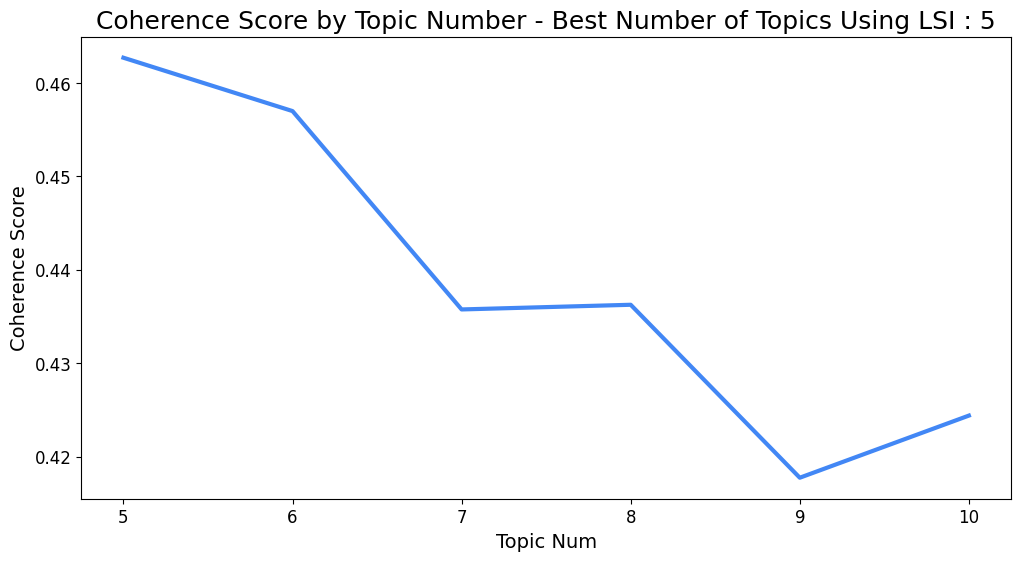

In [68]:
# Plot the results
fig = plt.figure(figsize=(12, 6))

plt.plot(
    topic_nums,
    lsi_coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics Using LSI : {}'.format(best_num_topics_lsi), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 1), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

**From above we have the Best Number of Topics derived using LSI Coherence Model**

**We will also check what topics have been selected and see whether these can be grouped together to meet the Assignment requirement to classify tickets into 5 categories, using our Business Domain Knowledge**


#### Best Number of Topics using LDA

**Latent Dirichlet Allocation (LDA) is a Bayesian network (and, therefore, a generative statistical model) that explains a set of observations through unobserved groups, and each group explains why some parts of the data are similar.**
    

In [69]:
lda_coherence_scores= []


for num in topic_nums:
    lda_model = models.LdaModel(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        random_state=42
        )


    cm = CoherenceModel(
        model=lda_model,
        texts=dataset,
        dictionary=dictionary,
        coherence='c_v')

    lda_coherence_scores.append(round(cm.get_coherence(), 5))
    data_topic_score.loc[len(data_topic_score.index)] = ['LDA', num, round(cm.get_coherence(), 5)]

In [70]:
data_topic_score

,Model,No. of Topics,Coherence
0,NMF,5,0.40529
1,NMF,6,0.42466
2,NMF,7,0.41501
3,NMF,8,0.43485
4,NMF,9,0.43948
5,NMF,10,0.42939
6,LSI,5,0.46270
7,LSI,6,0.45699
8,LSI,7,0.43576
9,LSI,8,0.43626


In [71]:
# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, lda_coherence_scores))
best_num_topics_lda = sorted(scores, key=itemgetter(1), reverse=True)[0][0]
print(lda_coherence_scores)

[0.4156, 0.41543, 0.41451, 0.40658, 0.41861, 0.41502]


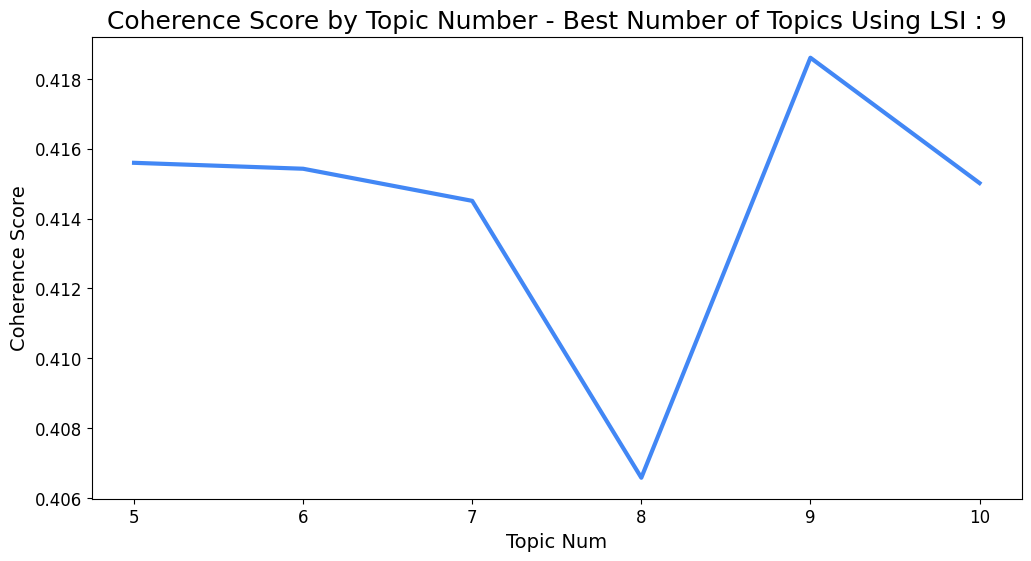

In [72]:
# Plot the results
fig = plt.figure(figsize=(12, 6))

plt.plot(
    topic_nums,
    lda_coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics Using LSI : {}'.format(best_num_topics_lda), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 1), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [73]:
# Print Scores
print(color.BOLD+color.CYAN+"Best Number of Topics using NMF : "+str(best_num_topics_nmf)+color.END)
print(color.BOLD+color.CYAN+"Best Number of Topics using LSI : "+str(best_num_topics_lsi)+color.END)
print(color.BOLD+color.CYAN+"Best Number of Topics using LSI : "+str(best_num_topics_lda)+color.END)

Best Number of Topics using NMF : 9
Best Number of Topics using LSI : 5
Best Number of Topics using LSI : 9


**From above we have the Best Number of Topics derived using LDA Coherence Model**

**We will also check what topics have been selected and see whether these can be grouped together to meet the Assignment requirement to classify tickets into 5 categories, using our Business Domain Knowledge**



**Notice that for each of Coherent Models (NMF, LSI, LDA), the number of topics varied.**

**We may have to apply our Business Domain Knowledge to group the Topics, so that they are more representable and Business relevant**

**We will now apply the Best Number of Topics obatain from Automated proecess and then apply our Business Knowledge to group the topics**

## Manual Topic Modeling
**We now have the number of topics from the Coherence Model**

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [74]:
# Feature Extration using the Best Number of Topics from Coherence Model
# oad your nmf_model with the n_components i.e 5
N_TOPICS = best_num_topics_nmf #write the value you want to test out

#keep the random_state =40
nmf_model = nmf = NMF(n_components=N_TOPICS) #write your code here

In [75]:
# Fit Model
W = nmf.fit_transform(dtm)  # Document-topic matrix
H = nmf.components_       # Topic-term matrix
len(vect.get_feature_names_out())

7077

In [76]:
#Print the Top15 words for each of the topics

words = np.array(vect.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((N_TOPICS, 15)), index=[f'Topic {i + 1}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(N_TOPICS):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,chase,checking,reason,access,branch,letter,business,deposit,balance,information,number,year,fund,activity
Topic 2,card,credit,chase,balance,limit,point,score,purchase,year,offer,time,application,service,month,customer
Topic 3,payment,month,balance,statement,auto,day,credit,time,date,pay,mortgage,report,car,error,chase
Topic 4,charge,dispute,merchant,chase,fraud,transaction,purchase,company,claim,statement,letter,service,refund,item,state
Topic 5,loan,mortgage,chase,home,modification,year,property,rate,letter,document,time,foreclosure,house,sale,request
Topic 6,report,inquiry,credit,company,reporting,information,debt,identity,score,jpmcb,bureaus,theft,date,inquire,bureau
Topic 7,check,deposit,fund,cash,bank,day,branch,hold,chase,business,cashier,teller,mail,money,customer
Topic 8,fee,balance,overdraft,charge,transfer,year,transaction,month,statement,dollar,bank,customer,fund,time,pay
Topic 9,bank,money,transaction,claim,fraud,fund,number,day,transfer,phone,debit,person,branch,atm,department


**Seems following can Fit**

- Topic 1,7 & 8 are related and fall under "Bank Account Services" - Based on the words Check, money, deposit, account, fund, transaction, fund
- Topic 2 : "Credit Card / Pre-Paid Card" - Credit, Score, limit, application, balance
- Topic 3, 5 are related and fall under "Loans/Mortgage" - Based on terms mortgage, home, property,
- Topic 4, 6 are related and fall under "Theft / Disputes / Fraud reporting" - charge, fee, dispute, fraud, refund, statement
- Topic 9  can be put under "Others" - Has mix of words from Bank Account, Credit / Pre-paid Card, Loans


**So Overall there seems to be 5 Topics, lets apply this and check the resultant Topics**

In [77]:
# Feature Extration applying the Business Knowledge and as per above observation
# oad your nmf_model with the n_components i.e 5
N_TOPICS = 5

#keep the random_state =40
nmf_model = nmf = NMF(n_components=N_TOPICS) #write your code here

In [78]:
# Fit Model
W = nmf.fit_transform(dtm)  # Document-topic matrix
H = nmf.components_       # Topic-term matrix
len(vect.get_feature_names_out())

7077

In [79]:
#Print the Top15 words for each of the topics

words = np.array(vect.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((N_TOPICS, 15)), index=[f'Topic {i + 1}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(N_TOPICS):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,number,business,transaction,claim,transfer,customer
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,information,debt,application,letter,balance,year
Topic 3,payment,balance,month,fee,statement,auto,day,time,pay,date,credit,account,chase,year,mortgage
Topic 4,charge,card,chase,fee,transaction,dispute,merchant,fraud,purchase,claim,service,time,refund,statement,company
Topic 5,loan,mortgage,home,chase,modification,property,year,letter,rate,time,document,bank,foreclosure,house,sale


**Resultant Topics can be classified as follows :**
- Topic 1 : 0 - Bank Account services
- Topic 2 : 1 - Credit/Prepaid card
- Topic 3 : 2 - Others
  - as it contains combination of words related to Bank, Credit/Prepaid card, Theft/Fraud/Dispute Reporting, Mortgage/Loan)
- Topic 4 : 3 : Theft/Fruad/Dispute Reporting
- Topic 5 : 4 : Mortgage/Loan


In [80]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
print(topic_results)

[[0.02212171 0.01312766 0.00651984 0.00771502 0.02236078]
 [0.008764   0.01458886 0.00212378 0.01224404 0.00597389]
 [0.         0.04905519 0.         0.00247195 0.        ]
 ...
 [0.01497242 0.01164822 0.         0.02548067 0.00999755]
 [0.         0.05190463 0.10035437 0.02131976 0.        ]
 [0.03145897 0.0327859  0.0946564  0.00348017 0.0041937 ]]


In [81]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [82]:
df_clean.shape

(21072, 5)

In [83]:
#Print the first 5 Complaint for each of the Topics
top5_clean=df_clean.groupby('Topic').head(5)
top5_clean.sort_values('Topic')

,Complaint_What_Happened,complaint_lemma,complaint_POS_rem,Complaint_clean,Topic
14,my grand son give me check for {$.} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen xx/xx/ check number xxxx claim number is xxxx with chase,my grand son give I check for { $ . } I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he I should call not he to verify the check owner he be out the country most the time date happen xx / xx/ check number xxxx claim number be xxxx with chase,son chase account fund bank account pay money son check money bank refuse money son call chase time check owner country time date number claim number chase,son chase account fund bank account pay money son check money bank refuse money son call chase time check owner country time date number claim number chase,0
17,"with out notice j.p. morgan chase restricted my account by my debit card tuesday xx/xx/. on thursday xx/xx/ i went into a branch after being advised by a customer service representative that my account would actually be closed. i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day. that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday, xx/xx/. upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement. ive been called and i was told that it may take two business day stating tuesday, xx/xx/xxxx would be the date that my funds would be available to withdraw from a bank teller only. now, chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently. unfortunately, this has put me in an additional financial bind do two fees from late rent late car payments, etc. i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document. i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document. this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally. thank you","with out notice j.p . morgan chase restrict my account by my debit card tuesday xx / xx/. on thursday xx / xx/ I go into a branch after be advise by a customer service representative that my account would actually be close . I go into the branch to see how I can remove the fund that be in there currently in as well as if my direct deposit from my place of employment would be return . the bank associate and 

**After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:**

* Bank Account services
* Credit/Prepaid card
* Theft/Fraud/Dispute Reporting
* Mortgage/Loan
* Others

In [84]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0 : 'Bank Account services',
    1 : 'Credit/Prepaid card',
    2 : 'Others',
    3 : 'Theft/Fraud/Dispute Reporting',
    4 : 'Mortgage/Loans'
   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [85]:
df_clean.shape

(21072, 5)

In [93]:
df_clean.head()

,Complaint_What_Happened,complaint_lemma,complaint_POS_rem,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,Mortgage/Loans
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent,card agent upgrade date agent information order account change date consent recording agent,Credit/Prepaid card
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,Credit/Prepaid card
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with t

**Lets verify the Coherence Scores for the Topics Mapped**

In [96]:
df_clean.Topic.unique()

array(['Mortgage/Loans', 'Credit/Prepaid card', 'Bank Account services',
       'Others', 'Theft/Fraud/Dispute Reporting'], dtype=object)

In [94]:
# Coherence model
from gensim.models.coherencemodel import CoherenceModel
c_topics = df_clean.Topic.unique()

cm = CoherenceModel(topics=c_topics,
        texts=dataset,
        dictionary=dictionary,
        coherence='c_v')

coherence_per_topic = cm.get_coherence_per_topic()

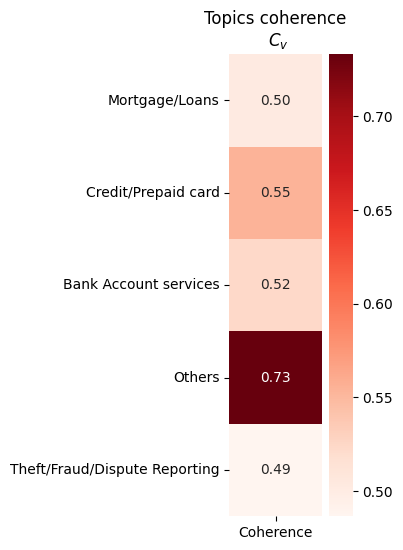

In [97]:
# Lets Plot and check the Coherence Scores
#topics_str = [ '\n '.join(t) for t in Topic_names ]
data_topic_score = pd.DataFrame( data=zip(c_topics, coherence_per_topic), columns=['Topic', 'Coherence'] )
data_topic_score = data_topic_score.set_index('Topic')
#fig = plt.figure(figsize=(12, 6))
fig, ax = plt.subplots( figsize=(2,6) )
ax.set_title("Topics coherence\n $C_v$")
sns.heatmap(data=data_topic_score, annot=True, square=True,
            cmap='Reds', fmt='.2f',
            linecolor='black', ax=ax )
plt.yticks( rotation=0 )
ax.set_xlabel('')
ax.set_ylabel('')
fig.show()

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [99]:
df_clean_copy = df_clean.copy()

In [100]:
#Create the dictionary again of Topic names and Topics
# Topic Mapping
Topic_names = {
    "Bank Account services" : 0,
    "Credit/Prepaid card" : 1,
    "Others" : 2,
    "Theft/Fraud/Dispute Reporting" : 3,
    "Mortgage/Loans" : 4
   }


#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [101]:
df_clean.shape

(21072, 5)

In [102]:
df_clean.head(5)

,Complaint_What_Happened,complaint_lemma,complaint_POS_rem,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service . \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable . I be ask the bank to validate the debt . instead I been receive mail every month from they attempt to collect a debt . \n I have a right to know this information as a consumer . \n\n chase account # xxxx xxxx xxxx xxxx thank in advance for your help .,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in xx / xx/ and be tell by the agent who do the upgrade my anniversary date would not change . it turn the agent be give I the wrong information in order to upgrade the account . xxxx change my anniversary date from xx / xx / xxxx to xx / xx / xxxx without my consent ! xxxx have the recording of the agent who be mislead I .,card agent upgrade date agent information order account xxxx change date xxxx consent recording agent,card agent upgrade date agent information order account change date consent recording agent,1
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.","chase card be report on xx / xx/. however , fraudulent application have be submit my identity without my consent to fraudulently obtain service . do not extend credit without verify the identity of the applicant .",card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by

In [103]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['Complaint_What_Happened','Topic']]

In [104]:
training_data.shape

(21072, 2)

In [105]:
training_data.head(5)

,Complaint_What_Happened,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services. \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable. i am asking the bank to validate the debt. instead i been receiving mail every month from them attempting to collect a debt. \ni have a right to know this information as a consumer. \n\nchase account # xxxx xxxx xxxx xxxx thanks in advance for your help.,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was told by the agent who did the upgrade my anniversary date would not change. it turned the agent was giving me the wrong information in order to upgrade the account. xxxx changed my anniversary date from xx/xx/xxxx to xx/xx/xxxx without my consent! xxxx has the recording of the agent who was misled me.,1
10,"chase card was reported on xx/xx/. however, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. do not extend credit without verifying the identity of the applicant.",1
11,"on xx/xx/, while trying to book a xxxx xxxx ticket, i came across an offer for {$.} to be applied towards the ticket if i applied for a rewards card. i put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. i immediately contacted xxxx and was referred to chase bank. i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why. i asked for more information about the xxxx offer and she explained that even if i had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account. i asked that the application be withdrawn and the representative obliged. this all happened no later than after putting in the application on xx/xx/. notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative, chase did in fact go ahead to open a credit account in my name on xx/xx/. this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error.",1
14,my grand son give me check for {$.} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen xx/xx/ check number xxxx claim number is xxxx with chase,0


In [106]:
# Lets Check the Training Data Set - Topic Wise rowcount
training_data['Topic'].value_counts()

0    5167
1    4961
3    4858
4    3808
2    2278
Name: Topic, dtype: int64

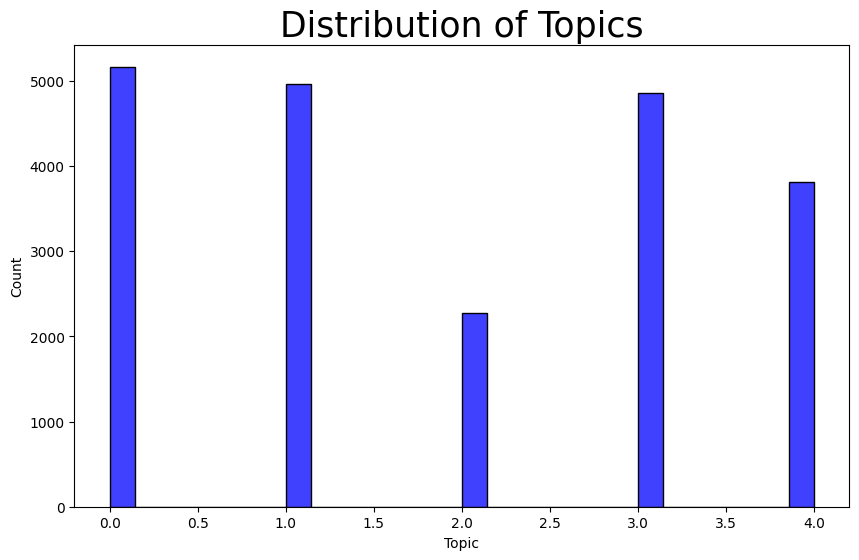

In [107]:
# Plotting a histogram of topics
plt.figure(figsize=[10,6])
sns.histplot(data=training_data, x='Topic',color='Blue', )
plt.title("Distribution of Topics", fontsize=25)
plt.show()

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [108]:
#Write your code to get the Vector count

# Create a Vectorizer Object
vectorizer = CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X_train_count=vectorizer.fit_transform(training_data['Complaint_What_Happened'])

# Transform the word vector to tf-idf
tfidf_transform= TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [109]:
# Saving Word Vector on disk for later usage
import pickle

pickle.dump(vectorizer.vocabulary_, open("vectorizer.pkl","wb"))
# Save TF-IDF on disk for later usage
pickle.dump(tfidf_transform, open("tfidf.pkl","wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [110]:
# Write your code here to build any 3 models and evaluate them using the required metrics
# First We perform Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")


X_train Shape: (15804, 27984)
y_train Shape: (15804,)
X_test Shape: (5268, 27984)
y_test Shape: (5268,)


In [111]:
# Create a function to evaluate models
def model_eval(y_test, y_pred, model_name):

    # print classification report of classifier
    print(color.BOLD+color.PURPLE+color.UNDERLINE+"CLASSIFICATION REPORT for "+ model_name+"\n"+color.END)
    print(color.BOLD+color.DARKCYAN+classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit/Prepaid card", "Others", "Theft/Fraud/Dispute Reporting",
"Mortgage/Loan"])+color.END)

    # plot confusion matrix of the classifier
    plt.figure(figsize=(7,7))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="RdYlGn", fmt='d', xticklabels=["Bank Account services", "Credit/Prepaid card", "Others", "Theft/Fraud/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()

    return

# Model 1 : Logistic Regression

In [112]:
# Import required library
from sklearn.linear_model import LogisticRegression

In [113]:
# Logistic Regression model with default parameters
model_name = 'Model 1 - Logistic Regression'
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [114]:
# Getting the score of the base model
lr.score(X_test, y_test)

0.9253986332574032

**The Model Prediction is at 92.54%, which is fairly good.**


**Let's check whether fine tuning the parameters will improve the prediction accuracy**\

In [115]:
# Hyperparameter tuning for best result
# Reference - https://www.geeksforgeeks.org/hyperparameter-tuning/
# Reference - https://levelup.gitconnected.com/a-comprehensive-analysis-of-hyperparameter-optimization-in-logistic-regression-models-521564c1bfc0

param_lr = {
    'penalty': ['l1', 'l2'],                                      # penalty in Logistic Regression Classifier i.e. L1 or L2 regularization
    'C': [0.001,0.01,0.1,1,10,100],                               # c tuning - Regularization Strength
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']   # Solver - computational
}

In [116]:
# Get Parameter
grid_lr = GridSearchCV(estimator=lr,
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


**Now that we have the Best Parameters, lets use them in the model**

In [117]:
# Creating model with best hyperparameter
lr_final = LogisticRegression(C=1,
                                  penalty='l1',
                                  solver='saga')

lr_final.fit(X_train, y_train)
y_pred_lr_final = lr_final.predict(X_test)

In [118]:
# Getting the score of the base model
lr_final.score(X_test, y_test)

0.9428625664388762

In [119]:
# Lets F1 Score - Weighted Average
# Calculate F1 Score of tuned model using weighted average method
f1_lr = f1_score(y_test, y_pred_lr_final, average="weighted")
f1_lr

0.9428076139157574

**Model Prediction has increased from 92.54% to 94.29%, which is a seems to be Good Score**

**Lets Evaluate the Model using the function created earlier**

#### Model 1 : Logistic Regression Evaluation

CLASSIFICATION REPORT for Model 1 - Logistic Regression

                               precision    recall  f1-score   support

        Bank Account services       0.95      0.96      0.95      1305
          Credit/Prepaid card       0.95      0.95      0.95      1265
                       Others       0.94      0.95      0.94       563
Theft/Fraud/Dispute Reporting       0.93      0.92      0.92      1222
                Mortgage/Loan       0.94      0.95      0.95       913

                     accuracy                           0.94      5268
                    macro avg       0.94      0.94      0.94      5268
                 weighted avg       0.94      0.94      0.94      5268



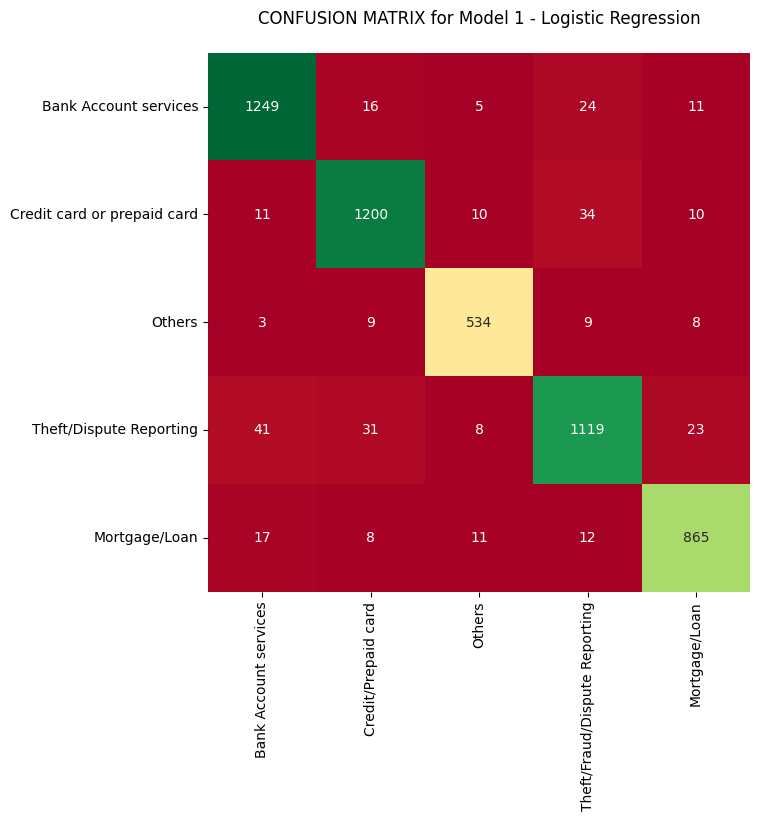

In [120]:
# Model Evaluation
model_name='Model 1 - Logistic Regression'
model_eval(y_test, y_pred_lr_final, model_name)

In [121]:
# Lets save the model
pickle.dump(lr_final, open("logreg_model.pkl", "wb"))

In [122]:
# Lets create a dataframe to store F1 Scores of all models we will build
f1_summary = pd.DataFrame([{'Model': 'Model 1- Logistic Regression','F1 Score': round(f1_lr, 2)}])
f1_summary

,Model,F1 Score
0,Model 1- Logistic Regression,0.94


###### Model 1 : Logistic Regression Observation
- The overall accuracy of the Logistic Regression model is 94%.
- F1 Score, Precision and Recall is in the range of 92% and 95% across the Topics

**Based the Observations, this is a GOOD Model**

# Model 2 : Decision Tree

In [123]:
# Import required library
from sklearn.tree import DecisionTreeClassifier

In [124]:
# Run Decision Tree with default hyperparameters
model_name = 'Model 2 : Decision Tree'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)

In [125]:
# Getting the score of the base model
dt.score(X_test, y_test)

0.7739179954441914

**With Default Parameters the Score is at 77.73%**

**Lets see whether we can improve this score by tuning the Hyperparameters**

In [126]:
# Hyperparameter tuning for best result
# Reference - https://www.section.io/engineering-education/hyperparmeter-tuning/

param_dt = {
    'criterion': ['gini', 'entropy'],       # Decides the measure of the quality of a split based on criteria like “gini” for the Gini impurity and “entropy” for the information gain
    'max_depth' : [5, 10, 15, 20, 25, 30],  # maximum depth of a tree.
    'min_samples_leaf':[1,5,10,15, 20, 25], # caps the minimum number of leaf nodes

}

grid_dt = GridSearchCV(estimator=dt,
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 15}


**Now we have Best Parameters for the Decision Tree**

**Lets now build Decision Tree Model using these Best PArameters**

In [127]:
# Creating model with best hyperparameter
dt_final = DecisionTreeClassifier(criterion='gini',
                                      max_depth=25,
                                      min_samples_leaf=15,
                                      )
dt_final.fit(X_train, y_train)
y_pred_dt_final = dt_final.predict(X_test)

In [128]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt = f1_score(y_test, y_pred_dt_final, average="weighted")
f1_dt

0.7915199378640627

**F1 Score with Best Parameters is bettered to 79.12%**

**Lets Evaluate the Model and Observe the Metrics**

#### Model Evaluation

CLASSIFICATION REPORT for Model 2 - Decision Tree

                               precision    recall  f1-score   support

        Bank Account services       0.78      0.82      0.80      1305
          Credit/Prepaid card       0.82      0.83      0.83      1265
                       Others       0.79      0.73      0.76       563
Theft/Fraud/Dispute Reporting       0.76      0.72      0.74      1222
                Mortgage/Loan       0.81      0.83      0.82       913

                     accuracy                           0.79      5268
                    macro avg       0.79      0.79      0.79      5268
                 weighted avg       0.79      0.79      0.79      5268



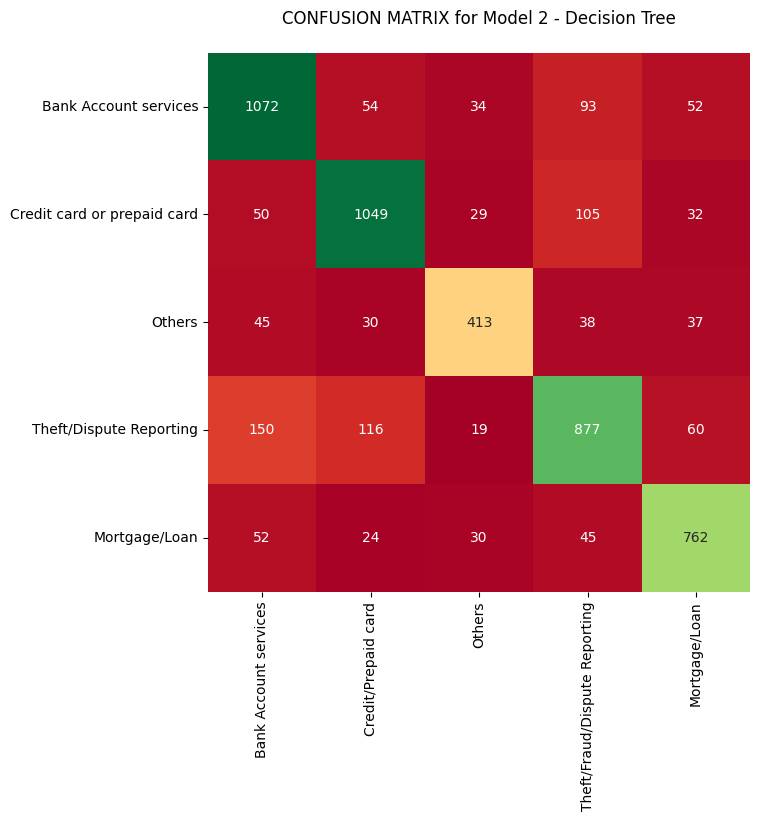

In [129]:
# Evaluate the tuned Decision Tree classifier
model_name='Model 2 - Decision Tree'
model_eval(y_test, y_pred_dt_final, model_name)

In [130]:
# Lets save the model
pickle.dump(dt_final, open("DT_model.pk1", "wb"))

In [131]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Model 2 - Decision Tree', round(f1_dt, 2)]
f1_summary

,Model,F1 Score
0,Model 1- Logistic Regression,0.94
1,Model 2 - Decision Tree,0.79


#### Model 2 - Decision Tree Observations
- The overall accuracy of the Decision Tree model is 79.12%.
- F1 Score, Precision and Recall is in the range of 72% and 86% across the Topics

**Based the Observations, the Logistic Regression Model is performing better than the Decision Tree Model**

# Model 3 - Random Forest

In [132]:
# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier
# Importing Train, Test Split
from sklearn.model_selection import train_test_split

In [133]:
# Random Forest with Default Parameters
model_name="Model 3 - Random Forest"
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [134]:
# Getting the score of the base model
rf.score(X_test, y_test)

0.8240318906605922

**The Model score with default parameters is around 82.40%**

**Lets find best parameters and then check whether using them will improve the score**

In [135]:
# Get Best Parameters - Hypertuning
# Reference - https://www.section.io/engineering-education/hyperparmeter-tuning/

rf_param = {
    "n_estimators": np.arange(10, 1000, 50),
    "max_depth": [3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2)
    }

grid_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_param,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
grid_rf.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [136]:
rf_final = grid_rf.best_estimator_
rf_final

RandomForestClassifier(max_depth=10, min_samples_split=8, n_estimators=810,
                       random_state=42)

**Now we have the Best Parameters for the model**

**Lets now use Best Parameters and check whether the accuracy score improves**

In [137]:
# Fit the model get the prediction
rf_final.fit(X_train, y_train)
y_pred_rf_final = rf_final.predict(X_test)

In [138]:
# Calculate F1 Score of tuned model using weighted average method
# Calculate F1 Score of tuned model using weighted average method
#f1_rf = f1_score(y_test, y_pred_rf_final, average="weighted")
f1_rf=rf_final.score(X_test, y_test)
f1_rf

0.7481017463933182

###### Model Evaluation

CLASSIFICATION REPORT for Model 3 - Random Forest

                               precision    recall  f1-score   support

        Bank Account services       0.73      0.92      0.81      1305
          Credit/Prepaid card       0.68      0.88      0.77      1265
                       Others       1.00      0.02      0.03       563
Theft/Fraud/Dispute Reporting       0.79      0.75      0.77      1222
                Mortgage/Loan       0.85      0.77      0.81       913

                     accuracy                           0.75      5268
                    macro avg       0.81      0.67      0.64      5268
                 weighted avg       0.78      0.75      0.71      5268



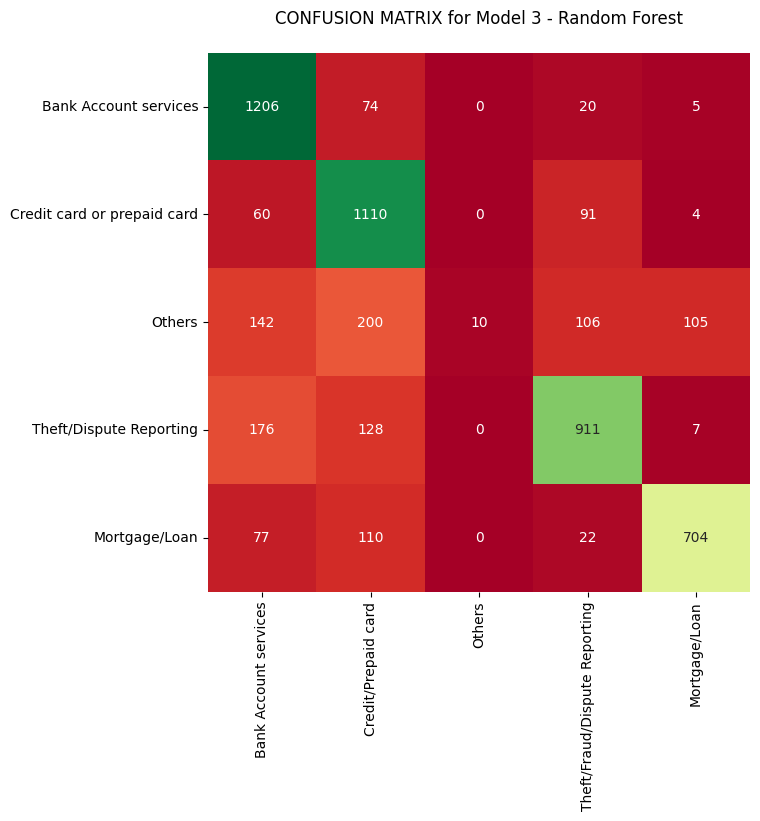

In [139]:
# Evaluate the tuned Decision Tree classifier
model_name='Model 3 - Random Forest'
model_eval(y_test, y_pred_rf_final, model_name)

In [140]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Model 3 - Random Forest', round(f1_rf, 2)]
f1_summary

,Model,F1 Score
0,Model 1- Logistic Regression,0.94
1,Model 2 - Decision Tree,0.79
2,Model 3 - Random Forest,0.75


#### Model 3 - Random Forest Observations
- The overall accuracy of the Random Forest model is 74%.
- F1 Score, Precision and Recall is in the range of 67% and 100% across the Topics

**Based the Observations, the Logistic Regression Model is performing better than the Decision Tree and Random Forest Models**

# Model 4 - Naive Bayes

In [141]:
# Import required library
from sklearn.naive_bayes import MultinomialNB

In [142]:
# Run the Multinomial Naive Bayes with default parameters
model_name = 'Model 4 - Naive Bayes'
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [143]:
nb.score(X_test, y_test)

0.7277904328018223

**The Model score with default parameters is around 72.78%**

**Lets find best parameters and then check whether using them will improve the score**

In [144]:
# Hyperparameter tuning for best result
param_nb = {
    'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),
    'fit_prior':[True, False]
}

grid_nb = GridSearchCV(estimator=nb,
                       param_grid=param_nb,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=10)
grid_nb.fit(X_train, y_train)
print(grid_nb.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_prior': False}


**Now we have the Best Parameters for the model**

**Lets now use Best Parameters and check whether the accuracy score improves**

In [145]:
# Creating model with best hyperparameter
nb_final = MultinomialNB(alpha=0.1,fit_prior=False)
nb_final.fit(X_train, y_train)
y_pred_nb_final = nb_final.predict(X_test)

In [146]:
# Calculate F1 Score of model using weighted average method
f1_nb = f1_score(y_test, y_pred_nb_final, average="weighted")
f1_nb

0.7786423379763958

#### Model Evaluation

CLASSIFICATION REPORT for Model 4 - Naive Bayes

                               precision    recall  f1-score   support

        Bank Account services       0.78      0.83      0.80      1305
          Credit/Prepaid card       0.80      0.75      0.77      1265
                       Others       0.66      0.63      0.65       563
Theft/Fraud/Dispute Reporting       0.77      0.77      0.77      1222
                Mortgage/Loan       0.83      0.84      0.84       913

                     accuracy                           0.78      5268
                    macro avg       0.77      0.77      0.77      5268
                 weighted avg       0.78      0.78      0.78      5268



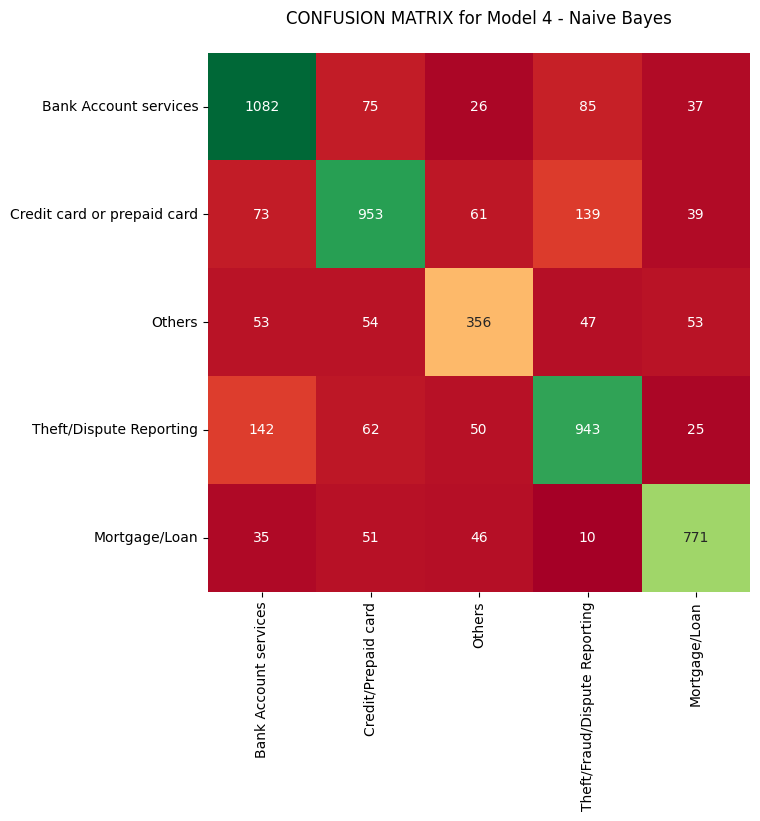

In [147]:
# Evaluate the Naive Bayes classifier
model_eval(y_test, y_pred_nb_final, model_name)

In [148]:
# Create a dataframe to store F1 Scores of all models we will build
f1_summary.loc[len(f1_summary.index)] = ['Model 4 - Naive Bayes', round(f1_nb, 2)]
f1_summary

,Model,F1 Score
0,Model 1- Logistic Regression,0.94
1,Model 2 - Decision Tree,0.79
2,Model 3 - Random Forest,0.75
3,Model 4 - Naive Bayes,0.78


#### Model 4 - Naive Bayes Observations
- The overall accuracy of the Naive Bayes model is 78%.
- F1 Score, Precision and Recall is in the range of 63% and 84% across the Topics

**Based the Observations, the Logistic Regression Model is performing better than the Decision Tree, Random Forest and Naive Bayes Models**

# Prediction Using the Best Model - Logistic Regression
#### Using Custom Text

In [161]:
# Create a dataframe of some sample customer complaints
df_complaints = pd.DataFrame({'complaints': ["I wish bring to your kind attention that I am having problems withdrawing money from my bank account. I hold an account under the names",
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "unwanted service activated and money deducted automatically ",
                                  "How can I know my CIBIL score?",
                                  "Where are the bank branches in the city of Hyderabad?",
                                  "I can not get from chase who services my mortgage, who owns it and who has original loan docs",
                                  "I want to dispute the card charges, as I think my card details have been stolen and hence want to report fraud transaction",
                                  "I have made payment against the claim and outstanding balances for all accounts, what are the payments still pending"]})
df_complaints

,complaints
0,I wish bring to your kind attention that I am having problems withdrawing money from my bank account. I hold an account under the names
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.
2,I want to open a salary account at your downtown branch. Please provide me the procedure.
3,unwanted service activated and money deducted automatically
4,How can I know my CIBIL score?
5,Where are the bank branches in the city of Hyderabad?
6,"I can not get from chase who services my mortgage, who owns it and who has original loan docs"
7,"I want to dispute the card charges, as I think my card details have been stolen and hence want to report fraud transaction"
8,"I have made payment against the claim and outstanding balances for all accounts, what are the payments still pending"


In [162]:
# Function to predict a topic for custom text

def complaint_predict(text):
    tfidf_transform= TfidfTransformer()
    target_names = ["Bank Account services", "Credit/Prepaid card", "Others", "Theft/Fraud/Dispute Reporting", "Mortgage/Loan"]

    load_vec = CountVectorizer(vocabulary=pickle.load(open("vectorizer.pkl", "rb")))
    load_tfidf = pickle.load(open("tfidf.pkl","rb"))
    load_model = pickle.load(open("logreg_model.pkl","rb"))

    X_new_count = load_vec.transform(text)
    X_new_tfidf = load_tfidf.transform(X_new_count,copy=True)
    prediction = load_model.predict(X_new_tfidf)

    return target_names[prediction[0]]

In [163]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_complaints['predicted topic'] = df_complaints['complaints'].apply(lambda x: complaint_predict([x]))
df_complaints

,complaints,predicted topic
0,I wish bring to your kind attention that I am having problems withdrawing money from my bank account. I hold an account under the names,Bank Account services
1,The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.,Credit/Prepaid card
2,I want to open a salary account at your downtown branch. Please provide me the procedure.,Bank Account services
3,unwanted service activated and money deducted automatically,Bank Account services
4,How can I know my CIBIL score?,Credit/Prepaid card
5,Where are the bank branches in the city of Hyderabad?,Bank Account services
6,"I can not get from chase who services my mortgage, who owns it and who has original loan docs",Mortgage/Loan
7,"I want to dispute the card charges, as I think my card details have been stolen and hence want to report fraud transaction",Theft/Fraud/Dispute Reporting
8,"I have made payment against the claim and outstanding balances for all accounts, what are the payments still pending",Others


# Final Summary

**Model 1 - Logistic Regression**
- The overall accuracy of the Logistic Regression model is 94%.
- F1 Score, Precision and Recall is in the range of 92% and 95% across the Topics

**Model 2 - Decision Tree**
- The overall accuracy of the Decision Tree model is 79.12%.
- F1 Score, Precision and Recall is in the range of 72% and 86% across the Topics

**Model 3 - Random Forest**
- The overall accuracy of the Random Forest model is 74%.
- F1 Score, Precision and Recall is in the range of 67% and 100% across the Topics

**Model 4 - Naive Bayes**
- The overall accuracy of the Naive Bayes model is 78%.
- F1 Score, Precision and Recall is in the range of 63% and 84% across the Topics

# Final Conclusion

**Logistic Regression Model performs better than rest of the models. We also confirmed this by Predicting the outcome of the Custom Complaints Text from Web.**

**Arrived at above conclusion, performing following process / activities**
- Data Reading/Data Understanding : Loaded the data set provided in Json format.
- Data Cleaning : Performed data cleaning operations like filtering text, removing missing values & renaming column headers.
- Data Preprocessing : Completed data processing using statistical operations - Lemmatization and POS tagging.
- Data Visualisation : Visualised the word count distribution & n-gram (unigram, bigram, trigram) distribution
- Feature Extraction : Features are extracted from the data using Td-Idf
- Topic Modelling
  - Auto Indentification of Topics - using Cohenrence Model for NMF, LSI and LDA.
  - Manual Topic Identification
    - Applied the Best Number of Topics from the Automation of Topic IDentification
    - Applied Business Knowledge/understanding and derived the final set of best cluster/Topics of 5.
- Model Building : Prepared Train and Test data using labels from NMF, applied the same to 4 models (Logistic Regression, Decision Tree, Random Forest, Naive Bayes), results / outcome mentioned above.
- Model Inference : Prediction using the best model (Logistic Regression).